In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tqdm
import random

import gc
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tqdm import tqdm

from PIL import Image
import PIL.Image
PIL.Image.MAX_IMAGE_PIXELS = 9000000000000

import tensorflow_datasets as tfds
import tensorflow as tf



from tensorflow import keras
from keras import layers

# Set up OpenSlide
OPENSLIDE_PATH = r'C:\openslide-win64-20221111\bin'

os.add_dll_directory(OPENSLIDE_PATH)
import openslide

from openslide import OpenSlide
# remove cap for image reading
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = pow(2,40).__str__()
import cv2 # import after setting OPENCV_IO_MAX_IMAGE_PIXELS

# Jobs:

+ Learn About [SHAP Values](https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137?gi=578a522915)

+ Check Domino Data lab

# To-do:

 + **Okay, so the Algorithm works, _kinda_.**.
  > Most of the windows (when the w_size is big) are blank
  > So, the chance of getting a good region decreases.
  **Ideas:**
   + Keep fixed the window size at a small number. Thus keeping the same big number of windows. And modify "check_cross" in order to expand to the desire window size.
   + Slide the image onto a rational aspect ratio (3:4 9:17 at most) 
 + Strenghten the **check_cross** function
 + Create a new convergence system:
 > The system should have a log(n) time complexity

 + Edit the loss scoring method and let it score higher when you find nucleoids + redcells + fat tissue
 

In [22]:
train = pd.read_csv('data/train.csv')
train.head()

,image_id,center_id,patient_id,image_num,label
0,006388_0,11,006388,0,CE
1,008e5c_0,11,008e5c,0,CE
2,00c058_0,11,00c058,0,LAA
3,01adc5_0,11,01adc5,0,LAA
4,026c97_0,4,026c97,0,CE


In [23]:
# scan files and filter the train.csv using scandir
## then filter only images that are present locally 
local = pd.DataFrame({"image_id": list(map(lambda x: (x.path).split(".")[0].split("/")[1], list(os.scandir("data/"))))})
train_local = pd.merge(train, local, how = "right").dropna()
train_local['file_path'] = train_local['image_id'].apply(lambda x: "data/" + x + ".tif")
train_local

,image_id,center_id,patient_id,image_num,label,file_path
0,008e5c_0,11.0,008e5c,0.0,CE,data/008e5c_0.tif
1,00c058_0,11.0,00c058,0.0,LAA,data/00c058_0.tif
2,01adc5_0,11.0,01adc5,0.0,LAA,data/01adc5_0.tif
3,026c97_0,4.0,026c97,0.0,CE,data/026c97_0.tif
4,028989_0,5.0,028989,0.0,LAA,data/028989_0.tif
5,029c68_0,5.0,029c68,0.0,CE,data/029c68_0.tif


In [24]:
def periodic(val, f):
    wave = np.cos(2 * np.pi * 1/f * val + 1/8 * np.pi) + 2  # arroz con güevo
    return wave

In [25]:
def get_loss(region):
    mat = np.array(region)/255.
    # treshold of squared colors
    tresh = 1.2
    # number of good choices
    good = 0
    N = mat.shape
    # resolution of the region (should be kept fixed)
    x_n, y_n = N[0], N[1]
    n_l = (np.ceil(x_n * 0.1), np.ceil(y_n * 0.1)) # check for 10% of the region
    
    # start
    x = 0
    y = 0
    # step 
    step = (x_n/n_l[0], y_n/n_l[1])
    for i in range(int(n_l[0])):
        y = 0
        pos_x = i * step[0]
        for j in range(int(n_l[1])):
            pos_y = j * step[1]
            # pick different values for the coordinates
            pixel = mat[x, y]
            
            # calculate the cost: check if the pixel in position x, y is not white
            res = np.sqrt(pixel[1]**2 + pixel[2]**2) + 0.1/(pixel[0] + 0.001)
            
            if res <= tresh:
                good += 1
            wave = periodic(pos_y, mat.shape[1])
            y += int(step[1] * 0.5 * wave)
        wave = periodic(pos_x, mat.shape[0])
        x += int(step[0] * 0.5 * (wave))
    # return the fraction of good pixels in the region
    res = good/max(n_l)
    if res >= 0.2:
        return res
    return 0

In [72]:
# Check the surrounding windows from the actual window being analyzed
def check_cross(slide, start_point, window_size, tresh):
    point = start_point
    m_loss = [0, 0, 0, 0]
    # check right
    point[0] += window_size[0]
    window = slide.read_region(point, 0, window_size)
    
    m_loss[1] = get_loss(window)

    # check left
    point[0] = start_point[0]
    point[0] -= window_size[0]
    window = slide.read_region(point, 0, window_size)
    m_loss[0] = get_loss(window)
    
    if m_loss[1] <= tresh and m_loss[0] <= tresh:
        print(f"||{m_loss}||")
        return m_loss
    
    # check bottom
    point[1] += window_size[1]
    window = slide.read_region(point, 0, window_size)
    m_loss[2] = get_loss(window)

    # check top
    point[1] = start_point[1]
    point[1] -= window_size[1]
    window = slide.read_region(point, 0, window_size)
    m_loss[3] = get_loss(window)
    # print(f"--{m_loss}--")
    return m_loss

In [91]:
# Checks the window from start_point and moves to the surroundings
def check_window(slide, point, good_tresh, window_size, p_step = 1, deep = 0):
    window = slide.read_region(point, 0, window_size)
    loss = get_loss(window)
    m_loss = [0, 0, 0, 0]
    if deep >= 4:
        return point, loss

    if loss >= good_tresh:
        m_loss = check_cross(slide, point, window_size, good_tresh)
        
        # caso base
        loss = min(m_loss)
        if loss >= good_tresh or max(m_loss) <= good_tresh:
            # print("Good")
            return loss, point
        # print("Not good")
        if m_loss[0] <= good_tresh and m_loss[1] >= good_tresh:
            # go right
            # print("GO right")
            if m_loss[2] <= good_tresh and m_loss[3] >= good_tresh:
                # go up
                # print("go up")
                point[0] += window_size[0] * p_step
                point[1] += window_size[1] * p_step
                return check_window(slide, point, good_tresh, window_size, p_step, deep + 1)
                
            elif m_loss[2] >= good_tresh and m_loss[3] <= good_tresh:
                # go down
                # print("Go down")
                point[0] += window_size[0] * p_step
                point[1] -= window_size[1] * p_step
                return check_window(slide, point, good_tresh, window_size, p_step, deep + 1)
                
        elif m_loss[0] >= good_tresh and m_loss[1] <= good_tresh:
            # go left
            # print("Go left")
            if m_loss[2] <= good_tresh and m_loss[3] >= good_tresh:
                # go up
                # print("go up")
                point[0] -= window_size[0] * p_step
                point[1] += window_size[1] * p_step
                return check_window(slide, point, good_tresh, window_size, p_step, deep + 1)
                
            elif m_loss[2] >= good_tresh and m_loss[3] <= good_tresh:
                # go down
                # print("Go down")
                point[0] -= window_size[0] * p_step
                point[1] -= window_size[1] * p_step
                return check_window(slide, point, good_tresh, window_size, p_step, deep + 1)    
    # big if 
    # print(f"NOpe {loss}")
    
    return loss, point
    

In [84]:
def function(path, n_pixels = 3.6e6, window_size = (100, 100)):
    # get width and height of image
    _ = PIL.Image.open(path)
    width, height = _.size

    # Number of windows 
    n_windows = int(n_pixels / (window_size[0] * window_size[1]))

    # Aspect ratio
    # this is a 2d surface
    R = height / width
    n_x = round(np.sqrt(n_windows/R))
    n_y = round(n_x * R)

    # number of pixels between each (window_size) window
    step = (int((width - window_size[0] * n_x) / n_x) if n_x > 1 else 0, int((height - window_size[1] * n_y) / n_y) if n_y > 1 else 0)
    print(f"window_size={window_size }, n_x={n_x}, n_y={n_y}")
    print(f"n_windows={n_windows}, N={width*height}, Step={step}")
    start = [500, 500]
    # this could be a BST
    top_regions = [0, 0, 0]
    top_losses = [0, 0, 0]
    min_loss = 0
    slide = OpenSlide(path)
    for i in range(n_y):
        for j in range(n_x):
            # read and score region
            ## the score shoulud be based on the ammount of information present on the window 
            ## + the ammount of info present on the surroundings
            loss, region = check_window(slide, start, 2, window_size)
            # print(f"Done {i}:{j}")
            if loss > min_loss:
                idx = top_losses.index(min_loss)
                top_regions[idx] = region.copy()
                top_losses[idx] = loss
                min_loss = min(top_losses)

            start[0] += step[0]
            
        start[1] += step[1]
    return max(top_losses), top_regions[top_losses.index(max(top_losses))]

window_size=(500, 500), n_x=2, n_y=10
n_windows=14, N=176560524, Step=(2473, 2469)


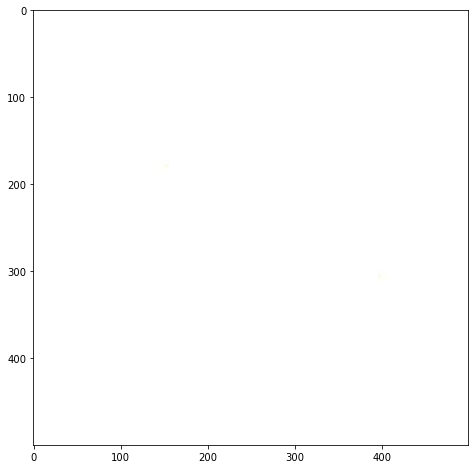

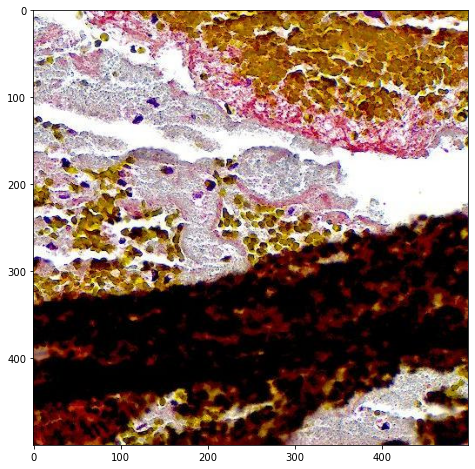

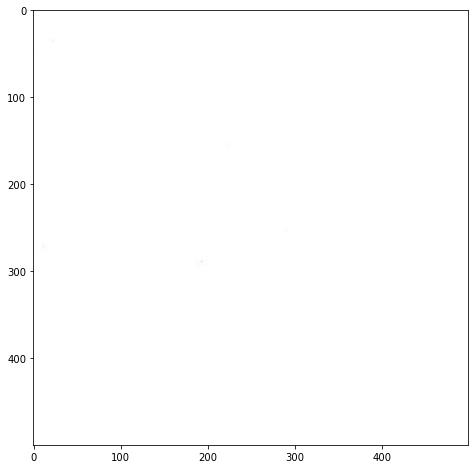

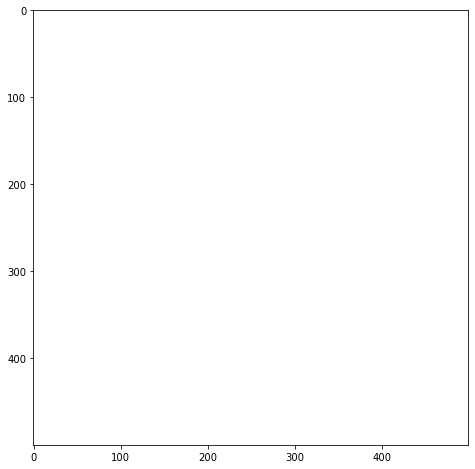

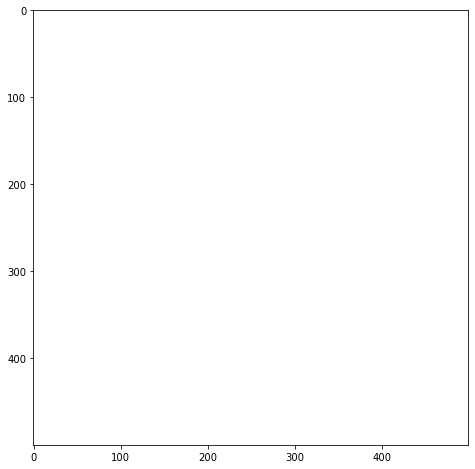

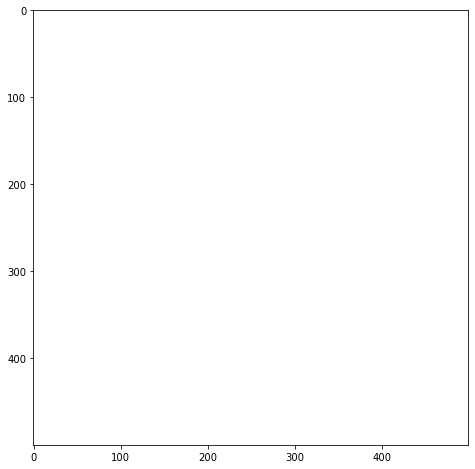

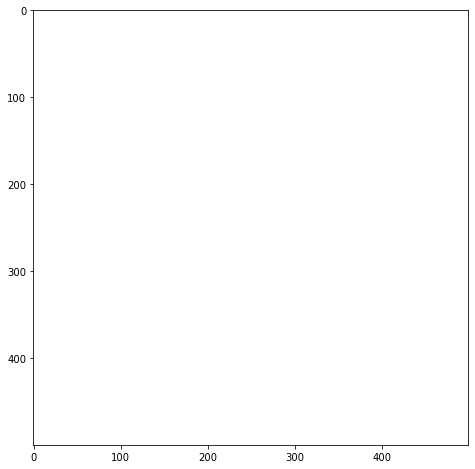

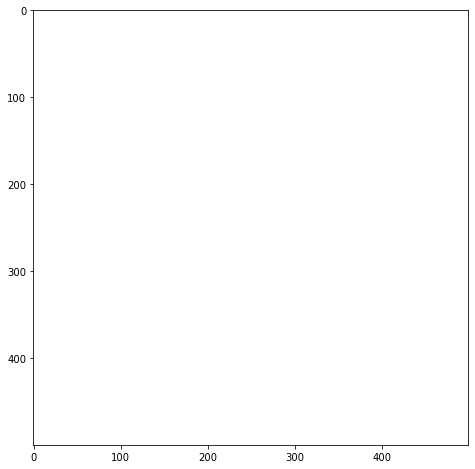

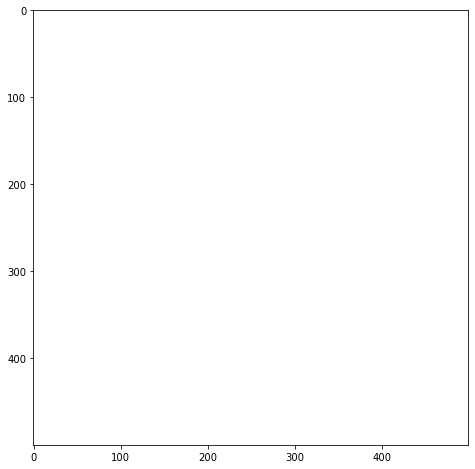

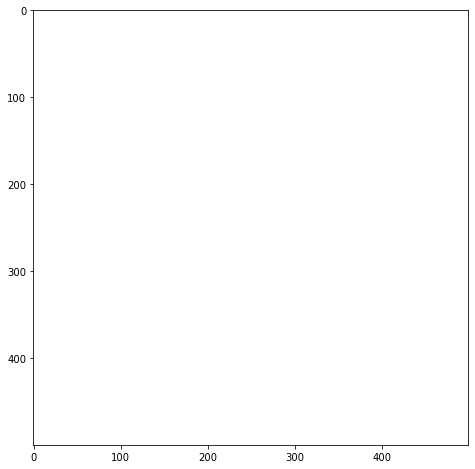

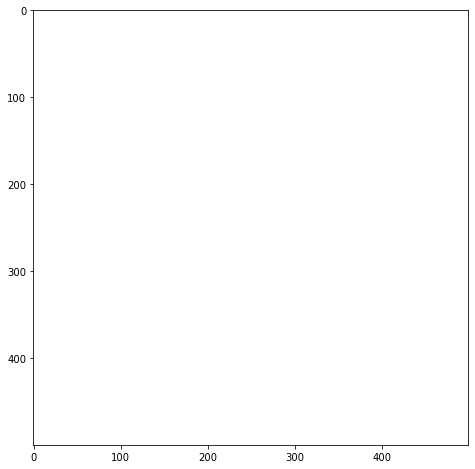

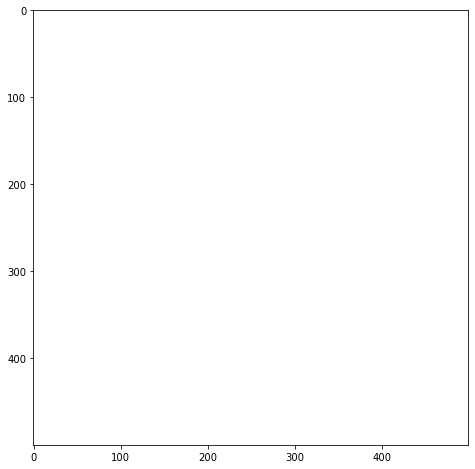

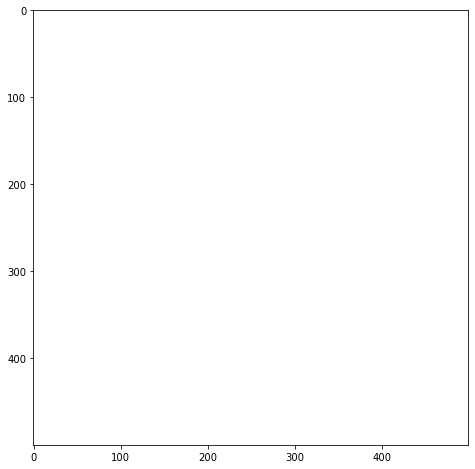

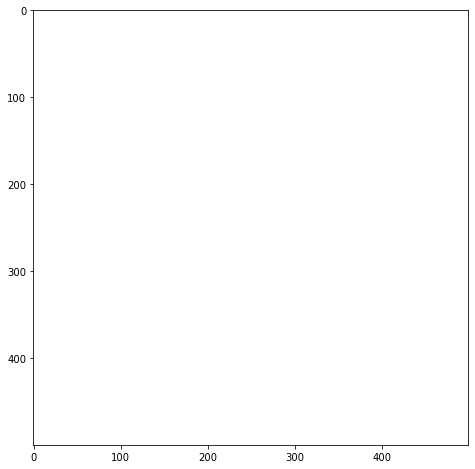

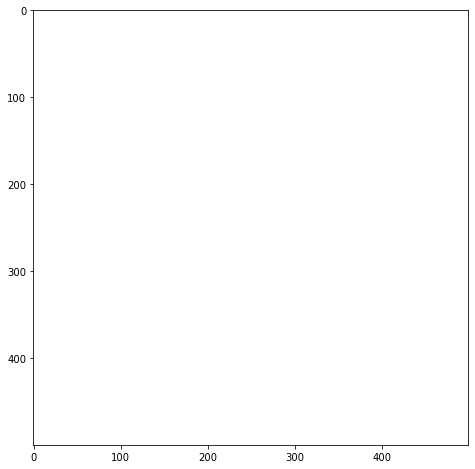

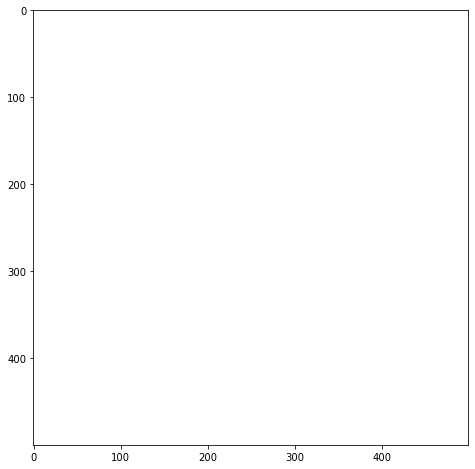

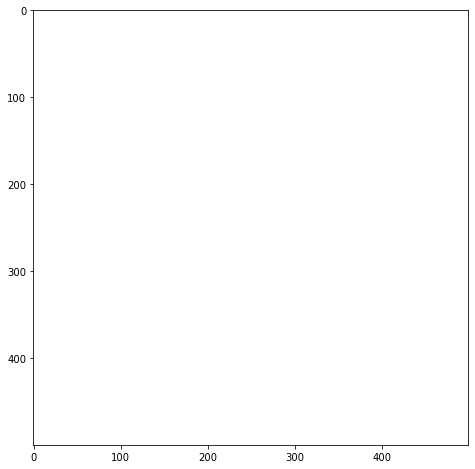

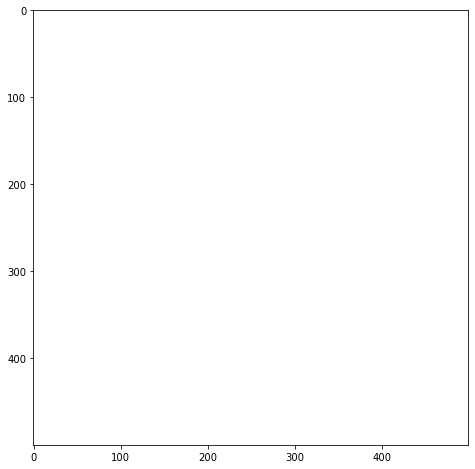

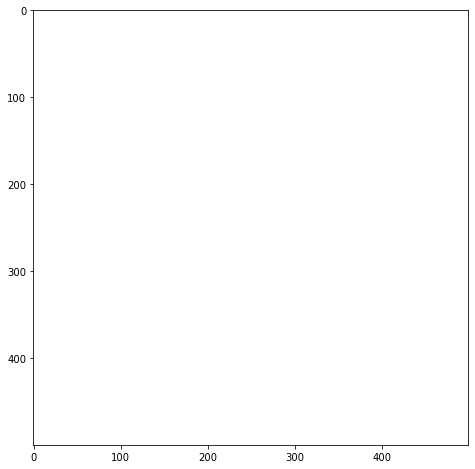

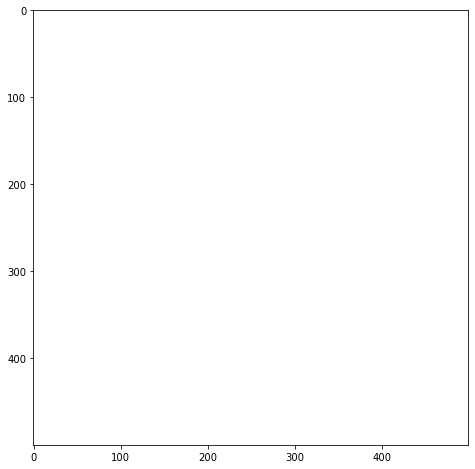

Pic data/008e5c_0.tif
23.28 [2973, 500]


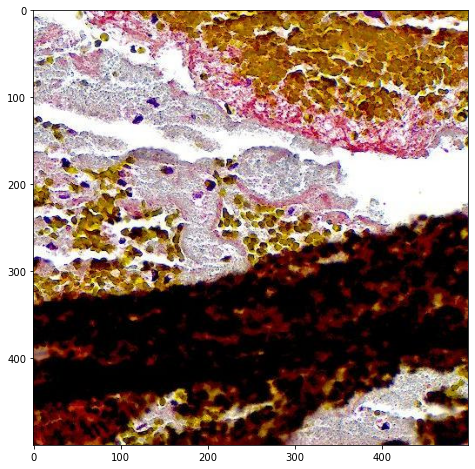

Done!


In [90]:

window_size = (500, 500)
for path in train_local.file_path.take([0]):
    loss, region = function(path, window_size = window_size)
    print(f"Pic {path}")
    slide = OpenSlide(path)
    window = slide.read_region(region, 0, window_size)
    print(loss, region)
    plt.figure(figsize = (8, 8))
    plt.imshow(window)
    plt.show()
    print("Done!")

In [ ]:
varios = train[train['label'] == 'CE'].iloc[0:2].file_path.to_numpy()
varios = np.concatenate([varios, train[train['label'] == 'LAA'].iloc[0:2].file_path.to_numpy()])
varios

In [ ]:
%%time
sample_train = train[:20]
regions = []
losses = []

varios = train[train['label'] == 'CE'].iloc[0:5].file_path.to_numpy()
varios = np.concatenate([varios, train[train['label'] == 'LAA'].iloc[0:5].file_path.to_numpy()])

im = PIL.Image.open(varios[0])
print(im.size)

# the default max_size of pics is 30_000 x 30_000
for i in varios:
    path = i
#     slide = OpenSlide(path)
    loss, region = function(path)
    print(f"Pic {path}")
    window = slide.read_region(region, 0, (800, 800))
    print(loss, region)
    plt.figure(figsize = (8, 8))
    plt.imshow(window)
    plt.show()
    size = (800, 800)
    x = 500
    y = 500
    print("Done!")

In [ ]:
# directly process the data
def process(path):
    size  = (800, 800)
    slide = OpenSlide(path)
    loss, region = function(slide)
    image = slide.read_region(region, 0, size)
    plt.figure(figsize = (8, 8))
    plt.imshow(image)
    plt.show()
    image = tf.image.resize(image, (512, 512))
    return image

In [ ]:
X = []
for path in tqdm(train['file_path']):
    print(f"Processing {path}")
    image = process(path)
    X.append(image)
    name = path.split("/")[-1]
    tf.keras.utils.save_img(f"/kaggle/working/processed/{name}", image)

In [ ]:
toy = train.copy()
files = []
paths = os.scandir("/kaggle/working/processed")
for part in paths:
    if part.is_file() and (part.name.find("tif") > 0):
        files.append(part.name)
        

toy = toy.set_index('image_id')

for file in files:
    print()
    name = file.split(".")[0]
    label = toy.loc[name, 'label']
    print(name, label)

In [ ]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * drop ** np.floor((epoch)/epochs_drop)
    return lrate

l_rate = LearningRateScheduler(step_decay)
earstop = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 5)

In [ ]:
shapes = (512, 512, 4)

input_layer = layers.Input(name = 'input', shape = shapes)
conv_1 = layers.Conv2D(filters=32, kernel_size = (3,3), strides =2, padding = 'same', activation = 'relu', input_shape = shapes, name = 'conv_1')(input_layer)
conv_2 = layers.Conv2D(filters=64, kernel_size = (3,3), strides =2, padding = 'same', activation = 'relu', name = 'conv_2')(conv_1)
conv_3 = layers.Conv2D(filters=32, kernel_size = (3,3), strides =2, padding = 'same', activation = 'relu', name = 'conv_3')(conv_2)
flat = layers.Flatten()(conv_3)
h1 = layers.Dense(128, activation = 'relu', name = 'h1')(flat)
drop = layers.Dropout(0.25)(h1)
output = layers.Dense(1, activation = 'sigmoid', name = 'prediction')(h1)

model = tf.keras.Model(input_layer, output)

model.compile(optimizer = 'adam', 
                loss = tf.keras.losses.BinaryCrossentropy(), 
                 metrics = ['accuracy', 'mse', 'mape']
             )

tf.keras.utils.plot_model(model)

In [ ]:
vocab = train['label'].unique().tolist()
Y = train['label'].apply(lambda x: vocab.index(x))

In [ ]:
ret = pd.DataFrame((X, Y)).transpose()
ret.columns = ['input', 'label']
ret.to_csv('processed.csv', index = False, header = None)

In [ ]:

dataset = pd.read_csv('processed.csv')
train, test = train_test_split(dataset, test_size = 0.2)
train, val = train_test_split(dataset, test_size = 0.2)

train = tf.data.Dataset.from_tensor_slices((dict(train))).batch(BATCH_SIZE)
val = tf.data.Dataset.from_tensor_slices((dict(val))).batch(BATCH_SIZE)
test = tf.data.Dataset.from_tensor_slices((dict(test))).batch(1)
dataset.head()

In [ ]:
for i in train.take(1):
    print(i)

In [ ]:
EPOCHS = 20
STEPS_X_EPOCH = 2
history = model.fit(train, validation_data = val, epochs = EPOCHS, callbacks = [l_rate, earstop])

In [ ]:
pred = model.predict(test_df)
pred

In [ ]:
y = y_test.to_numpy()
y_ = []
for i in pred:
    i_r = i.round()
    if i_r >= 1:
        y_.append(1)
    else:
        y_.append(0)

print(f" Accuracy: {1 - sum(abs(y - y_))/len(y_)}")

In [ ]:
X

In [ ]:
for __ in test_df.take(1):
    print(__)